# Important Libraries

In [2]:
import glob, os
import cv2 as cv
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout,BatchNormalization
from keras.models import Sequential
import tensorflow as tf
import keras
from keras import optimizers
from glob import glob
from sklearn.model_selection import train_test_split
from itertools import repeat

In [3]:
dataset_dir = '/kaggle/input/new-sit-stand/sit_stand_dataset'
classes = sorted(os.listdir(dataset_dir))

# Loading the data with Custom Datagen

In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 128, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.image_h = image_h
        self.image_w = image_w
        #self.classes = ['negative','sit', 'stand']
        #self.num_classes = len(self.classes)
        self.shuffle = shuffle
        
        self.n = len(self.df)

    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
    
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,[self.image_h,self.image_w]).numpy()

        return image_arr/255.
    
    def __get_output(self, label):
        return label
    
    def __get_data(self, x_batches, y_batches):
        # Generates data containing batch_size samples
        X_batchs = np.asarray([self.__get_input(x) for x in x_batches])
        y_batches = np.asarray(self.__get_output(y_batches))
        return X_batchs,y_batches
    
    def __getitem__(self, index):
        
        X_batches = self.X_col[index*self.batch_size : (index+1)*self.batch_size]
        Y_batches = self.y_col[index*self.batch_size : (index+1)*self.batch_size]
        X,y= self.__get_data(X_batches,Y_batches)       
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [5]:
data_dir = "/kaggle/input/new-sit-stand/sit_stand_dataset"

negative_path = data_dir + "/negative"
sit_path = data_dir+"/sit"
stand_path = data_dir+"/stand"

In [6]:
negative_images_paths = glob(f'{negative_path}/*.jpg')
sit_images_paths = glob(f'{sit_path}/*.jpg')
stand_images_paths = glob(f'{stand_path}/*.jpg')

negative_labels = []
sit_labels = []
stand_labels = []

negative_labels.extend(repeat(0, len(negative_images_paths)))
sit_labels.extend(repeat(1, len(sit_images_paths)))
stand_labels.extend(repeat(2,len(stand_images_paths)))

In [7]:
print(len(negative_labels))

27502


In [8]:
negative_df = pd.DataFrame(list(zip(negative_images_paths, negative_labels)), columns = ['image', 'label'])
sit_df = pd.DataFrame(list(zip(sit_images_paths, sit_labels)), columns = ['image', 'label'])
stand_df = pd.DataFrame(list(zip(stand_images_paths, stand_labels)), columns = ['image', 'label'])


all_data  = pd.DataFrame(columns =['image', 'label'])
all_data = pd.concat([negative_df, sit_df, stand_df], ignore_index=True)

In [9]:
train, val = train_test_split(all_data, train_size=0.8,test_size=0.2)
train,test = train_test_split(train, train_size = 0.8,test_size = 0.2)

In [10]:
from tensorflow.keras.utils import to_categorical
x_train = train['image']
y_train = to_categorical(train['label'], 3)

x_test = test['image']
y_test = to_categorical(test['label'], 3)

x_val = val['image']
y_val = to_categorical(val['label'], 3)

In [11]:
print(y_test.shape)

(12336, 3)


In [12]:
batch_size = 32
image_h = 224
image_w = 128
train_set = CustomDataGen(train, X_col = x_train, y_col = y_train,
                         batch_size = batch_size, input_size = (image_h,image_w), shuffle= True)

val_set = CustomDataGen(val, X_col = x_val, y_col = y_val,
                         batch_size = batch_size, input_size = (image_h,image_w), shuffle= True)

In [13]:
batch_size = 16
test_set = CustomDataGen(test, X_col = x_test, y_col = y_test,
                         batch_size = batch_size, input_size = (image_h,image_w), shuffle= True)

In [14]:
print(test_set.__len__() * 16)

12336


(224, 128, 3)
[1. 0. 0.]


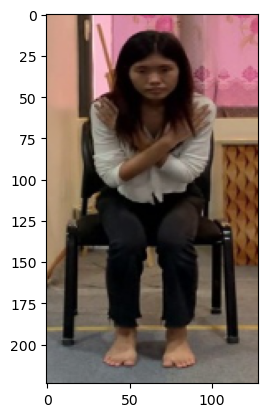

In [15]:
train_idx =5
x,y = train_set.__getitem__(8)
print(x[train_idx].shape)
print(y[train_idx])

plt.imshow(x[train_idx])
plt.show()

# Model Training with CNN

In [16]:
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(224, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 127, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 64, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 62, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 19, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 7, 64)        0

In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [19]:
batch_size = 32
hist = model.fit(train_set,validation_data=val_set,epochs = 25, batch_size = batch_size, steps_per_epoch = 10000//batch_size)

Epoch 1/25
312/312 [==============================] - 388s 1s/step - loss: 0.4779 - accuracy: 0.8028 - val_loss: 0.3903 - val_accuracy: 0.8342
Epoch 2/25
312/312 [==============================] - 180s 579ms/step - loss: 0.3434 - accuracy: 0.8617 - val_loss: 0.2645 - val_accuracy: 0.9066
Epoch 3/25
312/312 [==============================] - 168s 539ms/step - loss: 0.2700 - accuracy: 0.8926 - val_loss: 0.2251 - val_accuracy: 0.9146
Epoch 4/25
312/312 [==============================] - 159s 508ms/step - loss: 0.2474 - accuracy: 0.9080 - val_loss: 0.2043 - val_accuracy: 0.9229
Epoch 5/25
312/312 [==============================] - 144s 462ms/step - loss: 0.2253 - accuracy: 0.9115 - val_loss: 0.1912 - val_accuracy: 0.9249
Epoch 6/25
312/312 [==============================] - 141s 450ms/step - loss: 0.2149 - accuracy: 0.9158 - val_loss: 0.1932 - val_accuracy: 0.9214
Epoch 7/25
312/312 [==============================] - 135s 434ms/step - loss: 0.1890 - accuracy: 0.9267 - val_loss: 0.1820 - va

In [20]:
score = model.evaluate(test_set)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

771/771 [==============================] - 175s 227ms/step - loss: 0.1169 - accuracy: 0.9527
Accuracy for test images: 95.274 %


# Plotting the training and validation accuracy

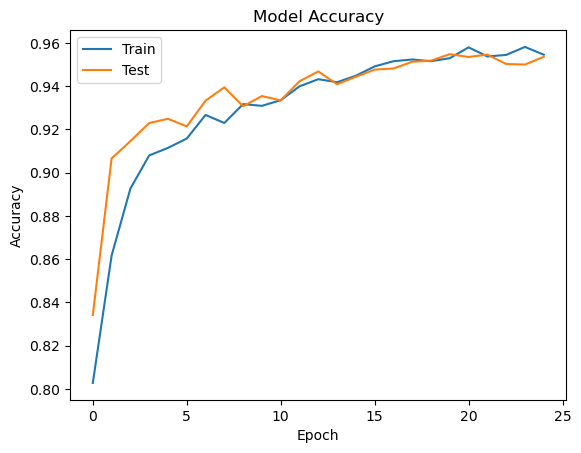

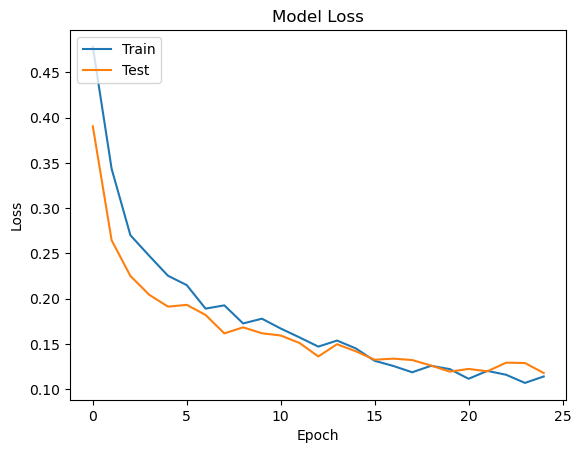

In [21]:
acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

%matplotlib inline

# Display History for Model Accuracy
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(acc)
plt.plot(val_acc)
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

# Display History for Model Loss
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [22]:
model.save('/kaggle/working/cnn_model_with_custom_gen_conv_layer_4.h5')

# Model Evaluation

In [23]:
y_pred = model.predict(test_set)

771/771 [==============================] - 56s 72ms/step


In [24]:
predict_value = []
for pred in y_pred:
    pred = np.argmax(pred)
    predict_value.append(pred)

In [25]:
print(len(predict_value))

12336


In [26]:
actual_values = []
for y in y_test:
  id=np.argmax(y)
  actual_values.append(id)

In [27]:
print(len(actual_values))

12336


In [28]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print('Accuracy Score',accuracy_score(actual_values, predict_value)*100,'%')
print('Precision Macro Score ',precision_score(actual_values, predict_value,average = 'macro')*100,'%')
print('Recall_Score',recall_score(actual_values, predict_value, average = 'macro')*100,'%')
print('F1_Score',f1_score(actual_values, predict_value, average = 'macro')*100,'%')

Accuracy Score 95.27399481193255 %
Precision Macro Score  95.1783339013136 %
Recall_Score 95.45818147592833 %
F1_Score 95.28267026915019 %


In [29]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    #y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (9, 5))
    #plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix', transparent=True, dpi=500)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

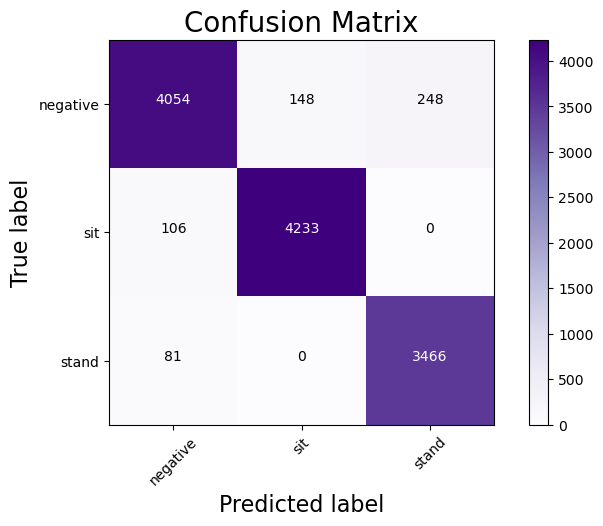

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(test_set, batch_size = 16, verbose = 0)
plot_confusion_matrix(actual_values, y_test_pred)